In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import pandas as pd
from sklearn import preprocessing
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error,mean_absolute_error,mean_squared_error,r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [ ]:
# dataframe = pd.read_csv('/content/drive/MyDrive/WQA_data/Asian_site_ard2.csv')
dataframe = pd.read_csv('/content/drive/MyDrive/WQA_data/AvantiCombined_NSR.csv')
# dataframe = pd.read_csv('/content/drive/MyDrive/WQA_data/AvantiCombined_SR.csv')
dataframe = dataframe[dataframe["Coincidence"] < 1].reset_index()
dataframe = dataframe.drop(columns=["index"])
dataframe = dataframe[dataframe['Salinity']>20]

In [ ]:
dataframe.head()

,PondID,pH,Salinity,Carbonate,BiCarbonate,Alkalinity,Hardness,Calcium,Magnesium,Ammonia,...,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9
0,TUPILIPALEM_A2,8.4,35,30,120,150,6300,388,1296,0.0,...,612,1253,1154,919,1025,1059,1171,920,1188,165
1,TUPILIPALEM_A3,8.7,38,40,120,160,6800,472,1471,0.0,...,484,1179,1065,794,854,918,1042,737,993,131
2,TUPILIPALEM_A4,8.7,39,40,110,150,6960,482,1488,0.0,...,432,1114,969,708,779,727,825,641,897,170
3,TUPILIPALEM_A5,8.7,40,40,120,160,7100,488,1491,0.0,...,524,1127,950,798,734,844,963,614,952,157
4,TUPILIPALEM_B2,8.6,36,50,110,160,6200,378,1302,0.0,...,710,1236,1162,1108,1114,1217,1268,828,1254,169


In [ ]:
dataframe = dataframe.drop([8,16,25,11,12,15]) #outlier TUPILIPALEM_A3,TUPILIPALEM_B5,VAVILLAPALEM_A2

In [ ]:
# dataframe

In [ ]:

bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
wavelengths = [442.7,	492.4,559.8,664.6,704.1,740.5,782.8,832.8,864.7,945.1,1373.5,1613.7,2202.4]
parameters = ["pH", "Salinity", "Ammonia"]

In [ ]:


def calculateWQI(parameters):
    # order of parameters ph salinity ammonia
    expdf = pd.DataFrame()
    permissibleValuesParameters = np.array([8.5, 45, 0.5])
    summ = 0
    sumWn = 0
    weights =   np.array([0.30,0.30,0.4]) # np.array(parameters.std()/permissibleValuesParameters)
    weightsnormalized = weights/sum(weights)
    for column, sn, Wn in zip(parameters.columns, permissibleValuesParameters, weightsnormalized):
        vn = parameters[column]
        if column=="pH":
            vid = 7.5
        elif column=="Salinity":
            vid = 0
        else:
            vid = 0.0
        qn = 100*(vn - vid)/(sn-vid)

        summ = summ + (qn*Wn)
        sumWn = sumWn + Wn
    expdf['summ'] = summ
    expdf['qn'] = qn
    WQI = summ/sumWn
    return WQI,expdf



def harmonizedWQIcalculation(GT):
  min = np.array([7.5,9,0])
  max = np.array([8.7,43,0.12])
  permissibleWP = np.array([8.5,45,0.5])
  weights =  np.array(GT.std()/permissibleWP)
  weights_norm = weights/sum(weights)
  numP = len(weights_norm)
  rr = max - min
  allWQI  = np.array([])
  n = len(GT)
  for val in GT.values:
    i = 0
    Tsumm = np.array([])
    for para in val:
        qi =None
        summ = 0
        if  min[i] <= para  <= 0.10*rr[i]:
          qi = 5
        if  0.1*min[i] <= para  <= 0.20*rr[i]:
          qi = 15
        if  0.20*rr[i] <= para  <= 0.30*rr[i]:
          qi = 25
        if  0.30*rr[i] <= para  <= 0.40*rr[i]:
          qi = 35
        if  0.40*rr[i] <= para  <= 0.50*rr[i]:
          qi = 45
        if  0.50*rr[i] <= para  <= 0.60*rr[i]:
          qi = 55
        if  0.60*rr[i] <= para  <= 0.70*rr[i]:
          qi = 65
        if  0.70*rr[i] <= para  <= 0.80*rr[i]:
          qi = 75
        if  0.80*rr[i] <= para  <= 0.90*rr[i]:
          qi = 85
        if  0.90*rr[i] <= para  <= max[i]:
          qi = 95
        # print(qi,para,rr[i])
        summ += 1/qi
        i+=1
        Tsumm = np.append(Tsumm,summ)
    WQI = sum([(weights_norm[i])*math.sqrt(i+1/Tsumm[i]**2) for i in range(numP)])/numP
    allWQI = np.append(allWQI,WQI)

  return allWQI


(array([ 1.,  4.,  4.,  2.,  3.,  6.,  9.,  5., 11.,  5.]),
 array([17.86666667, 22.70666667, 27.54666667, 32.38666667, 37.22666667,
        42.06666667, 46.90666667, 51.74666667, 56.58666667, 61.42666667,
        66.26666667]),
 <BarContainer object of 10 artists>)

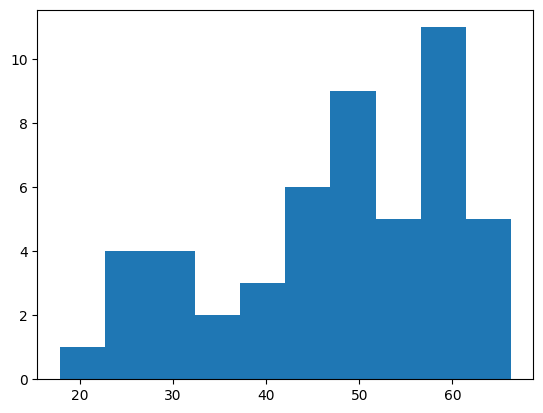

In [ ]:
wqi,expdf= calculateWQI(dataframe[parameters])
plt.hist(wqi)


In [ ]:
dataframe["WQI"] = wqi
dataframe.corrwith(dataframe["WQI"])

<ipython-input-485-f4503e108f89>:2: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataframe.corrwith(dataframe["WQI"])


pH             0.940532
Salinity       0.782753
Carbonate      0.844740
BiCarbonate   -0.053254
Alkalinity     0.264639
Hardness       0.019682
Calcium       -0.764542
Magnesium      0.771399
Ammonia       -0.373276
Coincidence         NaN
B1            -0.694319
B10           -0.362388
B11           -0.571523
B12           -0.534438
B2            -0.680460
B3            -0.619603
B4            -0.648548
B5            -0.665346
B6            -0.651146
B7            -0.638402
B8            -0.652520
B8A           -0.618545
B9            -0.478426
WQI            1.000000
dtype: float64

In [ ]:
x = dataframe[bands]
scaler = preprocessing.RobustScaler()
robust_df = scaler.fit_transform(x)
robust_df = pd.DataFrame(robust_df, columns =bands,index  = dataframe.index)

for band in bands:
  dataframe[band] = robust_df[band]

scaler2 = preprocessing.MinMaxScaler()
dataframe['WQI'] = scaler2.fit_transform(dataframe[['WQI']]).flatten()


In [ ]:
dataframe.head()

,PondID,pH,Salinity,Carbonate,BiCarbonate,Alkalinity,Hardness,Calcium,Magnesium,Ammonia,...,B2,B3,B4,B5,B6,B7,B8,B8A,B9,WQI
0,TUPILIPALEM_A2,8.4,35,30,120,150,6300,388,1296,0.0,...,0.066962,-0.037601,0.005997,-0.064648,0.043693,0.119813,0.107501,0.116249,-0.480861,0.670799
1,TUPILIPALEM_A3,8.7,38,40,120,160,6800,472,1471,0.0,...,-0.052441,-0.196956,-0.181409,-0.344517,-0.155039,-0.052878,-0.114789,-0.134232,-0.643541,0.898072
2,TUPILIPALEM_A4,8.7,39,40,110,150,6960,482,1488,0.0,...,-0.157322,-0.368845,-0.310345,-0.467267,-0.424242,-0.343373,-0.231400,-0.257547,-0.456938,0.911846
3,TUPILIPALEM_A5,8.7,40,40,120,160,7100,488,1491,0.0,...,-0.136345,-0.402865,-0.175412,-0.540917,-0.259338,-0.158635,-0.264197,-0.186898,-0.519139,0.925620
4,TUPILIPALEM_B2,8.6,36,50,110,160,6200,378,1302,0.0,...,0.039532,-0.023277,0.289355,0.081015,0.266385,0.249665,-0.004251,0.201028,-0.461722,0.808540


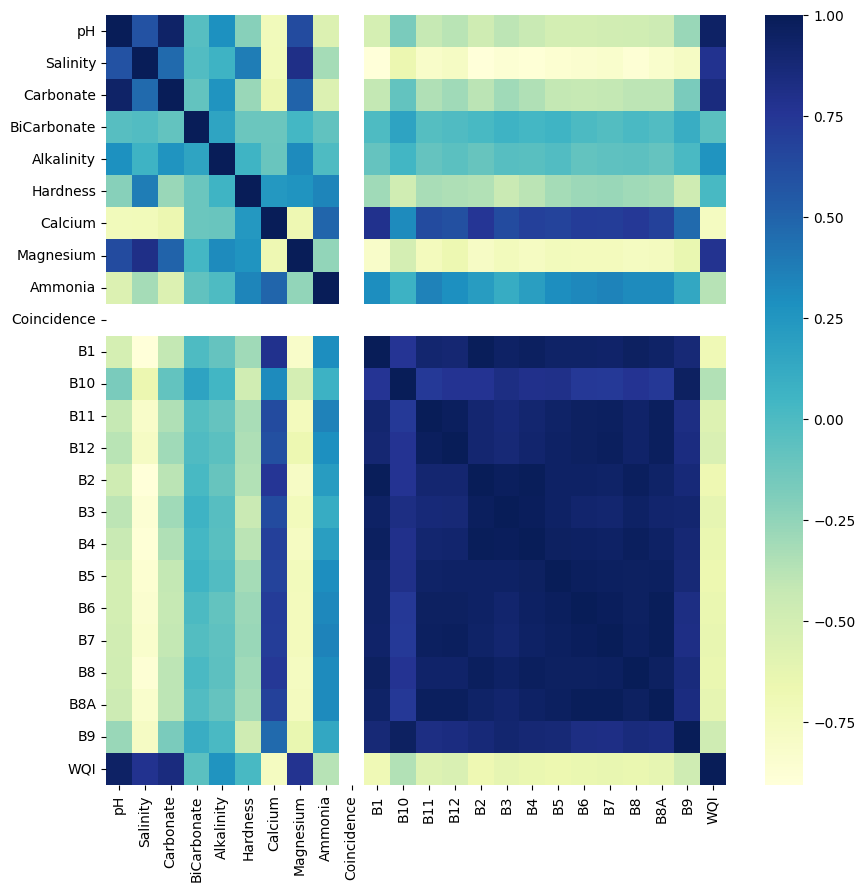

In [ ]:
tempdf = dataframe.drop(['PondID','DateofReport','Date of Image'],axis =1)
plt.figure(figsize=(10,10))
sns.heatmap(tempdf.corr(), annot=False,cmap="YlGnBu")
plt.show()


In [ ]:
NDWI = (dataframe["B3"] -dataframe["B8"] )/(dataframe["B3"] +dataframe["B8"] )
EWI = (dataframe["B3"] -dataframe["B8"] -dataframe["B11"])/(dataframe["B3"] +dataframe["B8"]+dataframe["B11"])
NWI = (dataframe["B1"] -(dataframe["B8"] +dataframe["B11"]+dataframe["B12"]))/(dataframe["B1"] +dataframe["B8"]+dataframe["B11"]+dataframe["B12"])

diff_B1_B2 = (dataframe['B1'] - dataframe['B2'])
norm_B9_B11 = (dataframe["B9"] -dataframe["B11"] )/(dataframe["B9"] +dataframe["B11"] )
diff_B9_B11 = (dataframe['B1'] - dataframe['B2'])
AWEI = 4 * (dataframe['B3'] - dataframe['B12'] ) - (2.5 * dataframe['B8']  + 2.75 * dataframe['B11'])

indicesdf = pd.DataFrame({'NDWI':NDWI,'EWI':EWI,'NWI': NWI,\
                          'diff_B1_B2':diff_B1_B2,'norm_B9_B11':norm_B9_B11,'diff_B9_B11':diff_B9_B11,'AWEI':AWEI})

In [ ]:
Totaldf = pd.concat([tempdf,indicesdf],axis=1)
Totaldf.head()

,pH,Salinity,Carbonate,BiCarbonate,Alkalinity,Hardness,Calcium,Magnesium,Ammonia,Coincidence,...,B8A,B9,WQI,NDWI,EWI,NWI,diff_B1_B2,norm_B9_B11,diff_B9_B11,AWEI
0,8.4,35,30,120,150,6300,388,1296,0.0,0,...,0.116249,-0.480861,0.670799,-2.075842,-1.497482,-5.723257,-0.205972,1.406730,-0.205972,-0.679057
1,8.7,38,40,120,160,6800,472,1471,0.0,0,...,-0.134232,-0.643541,0.898072,0.263572,-0.377004,-0.585410,-0.135222,0.335032,-0.135222,1.509835
2,8.7,39,40,110,150,6960,482,1488,0.0,0,...,-0.257547,-0.456938,0.911846,0.228982,-0.301580,-0.817174,0.047851,0.001047,0.047851,1.959802
3,8.7,40,40,120,160,7100,488,1491,0.0,0,...,-0.186898,-0.519139,0.925620,0.207879,-0.168961,-0.816735,0.059890,0.263693,0.059890,0.645801
4,8.6,36,50,110,160,6200,378,1302,0.0,0,...,0.201028,-0.461722,0.808540,0.691120,-1.131801,-1.187320,-0.091661,10.402654,-0.091661,-2.058362


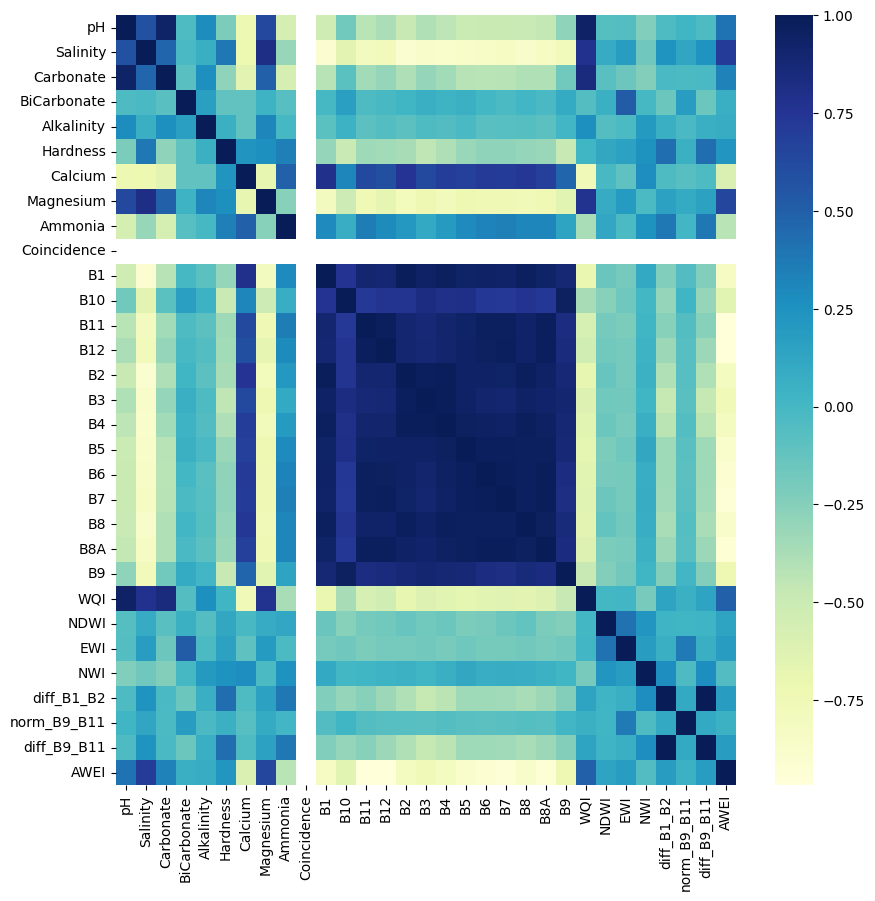

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(Totaldf.corr(), annot=False,cmap="YlGnBu")
plt.show()

In [ ]:
Totaldf['AWEI'].corr(Totaldf['WQI'])

0.4993084978093165

In [ ]:
def predictWQI(dataframe,pred,columns = bands):
    # validationdataframe = dataframe[dataframe["Date of Image"]=="2023-07-09"]
    # traindataframe = dataframe[dataframe["Date of Image"]!="2023-07-09"]

    traindataframe, validationdataframe = train_test_split(dataframe, test_size=0.3, random_state=42)
    # traindataframe.to_csv('WQIModelTrain.csv')
    # validationdataframe.to_csv('WQIModelTest.csv')

    # validationdataframe = dataframe[dataframe["Date of Image"]=="2022-09-12"]
    # traindataframe = dataframe[dataframe["Date of Image"]!="2022-09-12"]



    gtforRE = (validationdataframe[parameters])

    xTrain = ((traindataframe[columns]))
    yTrain = traindataframe[pred]
    xTest = ((validationdataframe[columns]))
    yTest = validationdataframe[pred]

    # model = SVR(kernel='rbf', C=1.0, epsilon=1e-4)
    model = LinearRegression()

    model.fit(xTrain, yTrain)
    prediction = model.predict(xTest)
    # for x,y in zip(yTest,prediction):
    #   print(x,'-',y)

    print("MAE", mean_absolute_error(yTest, prediction))
    print("MSE", mean_squared_error(yTest, prediction))
    print("RMSE", mean_squared_error(yTest, prediction, squared=False))
    print("MAPE", mean_absolute_percentage_error(yTest, prediction))
    print("R2 Score", r2_score(yTest, prediction))
    plt.figure(figsize=(25,10))
    plt.scatter(np.arange(1, len(yTest)+1), yTest, color="red")
    plt.plot(np.arange(1, len(yTest)+1), prediction, color="blue")

    return prediction,gtforRE

MAE 0.2005688339472062
MSE 0.056878262065022896
RMSE 0.23849163940277424
MAPE 126950076439166.14
R2 Score 0.16566589854900493


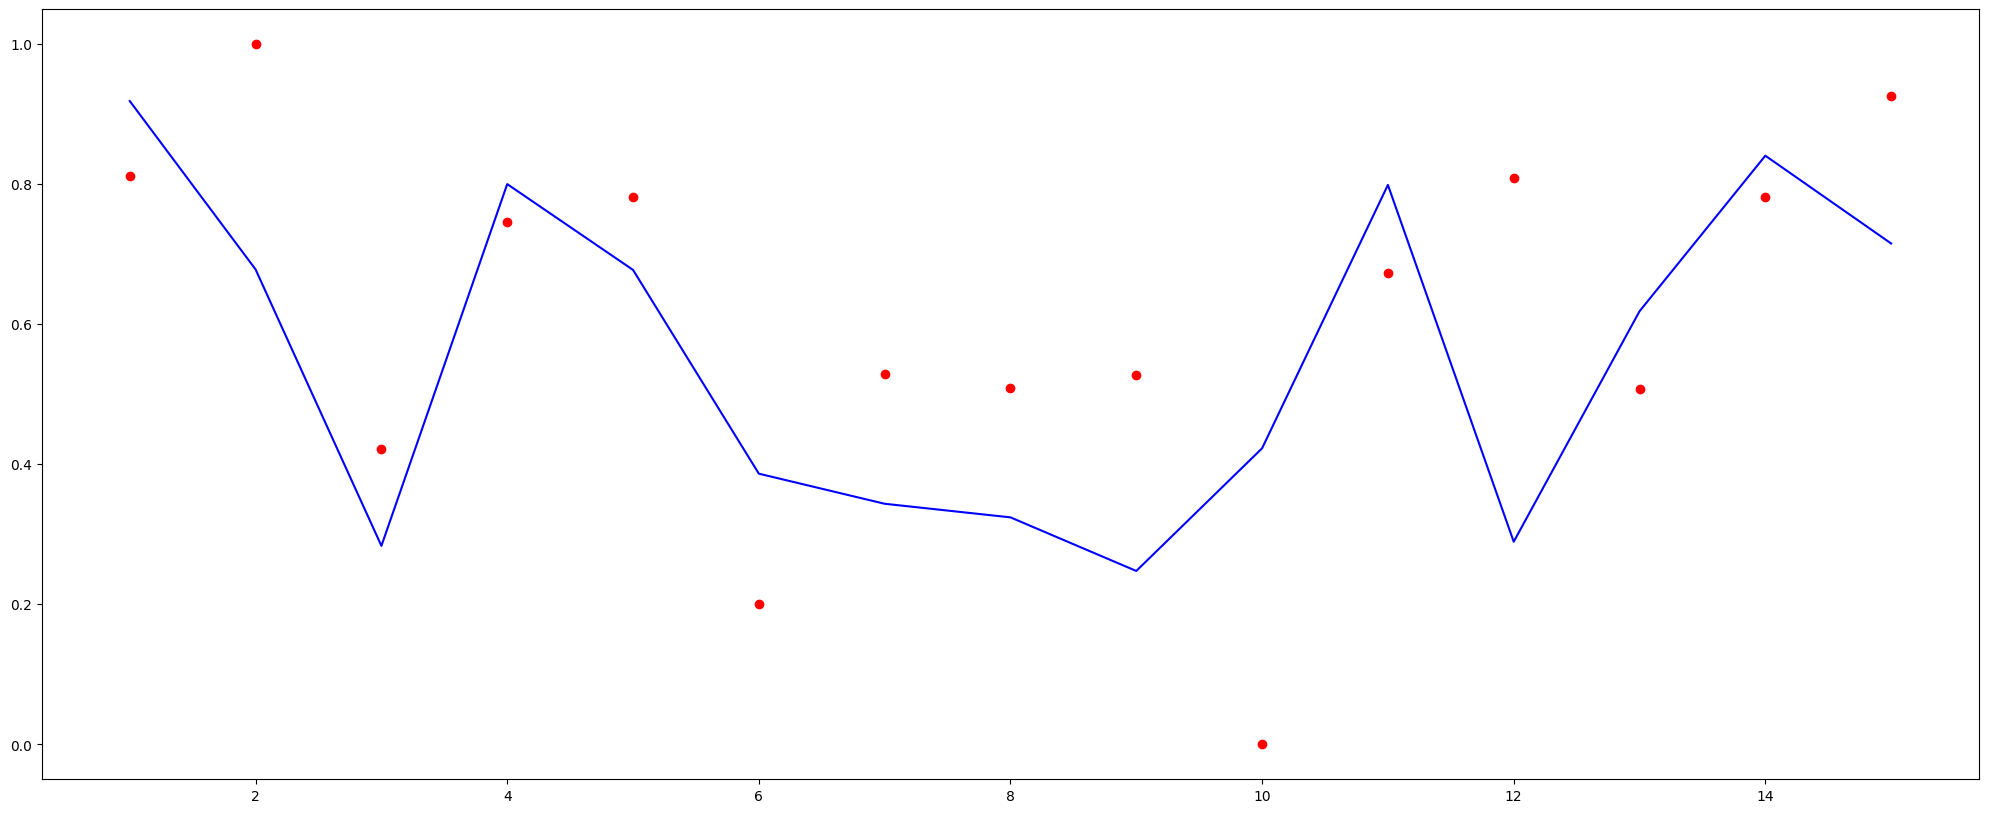

In [ ]:
Totaldf['Date of Image'] = dataframe['Date of Image']
# prediction,gtforRE = predictWQI(Totaldf,'WQI',columns = ['NDWI','EWI','AWEI','diff_B1_B2','norm_B9_B11'])
prediction,gtforRE = predictWQI(dataframe,'WQI',columns = bands)

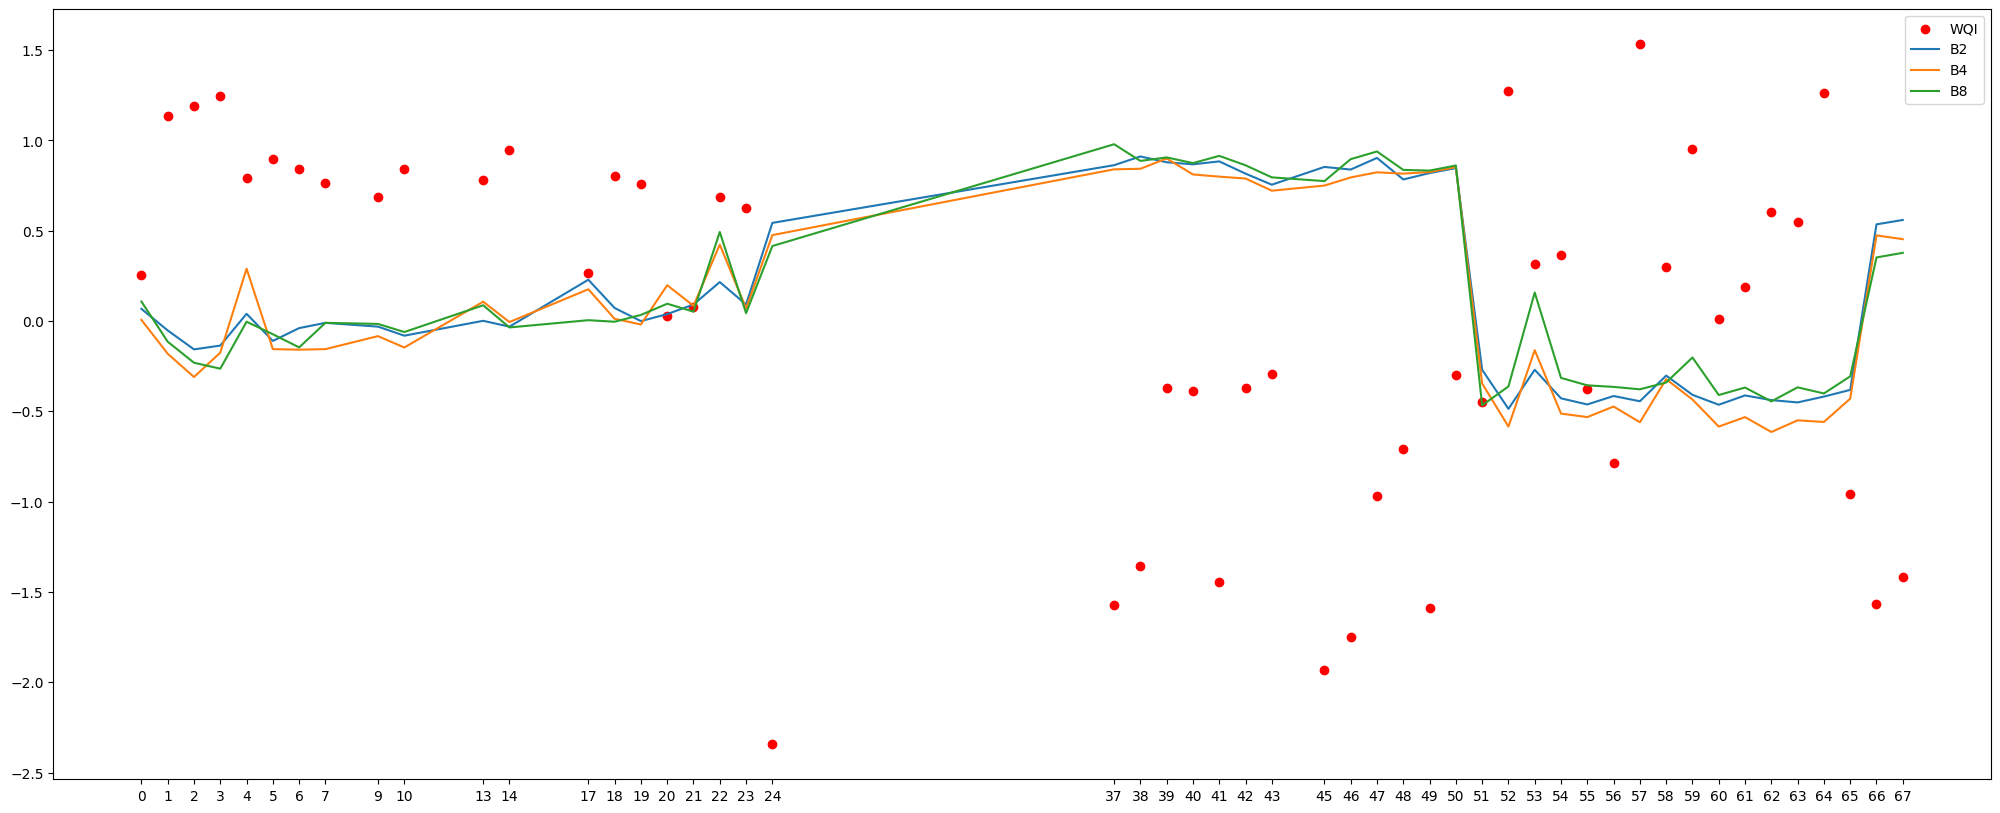

In [ ]:
plt.figure(figsize=(25,10))
gy = (dataframe['WQI'])
gy = (gy - gy.mean())/gy.std()
plt.scatter(dataframe.index, gy, color="red",label='WQI')
for band in ['B2','B4','B8']:
  y = dataframe[band]
  plt.plot(dataframe.index, y,label = band)
ndvi = (dataframe['B8']- dataframe['B4'])/ (dataframe['B8']+ dataframe['B4'])
# plt.plot(dataframe.index, ndvi,label = 'ndvi')
plt.xticks(dataframe.index)
plt.legend()
plt.show()


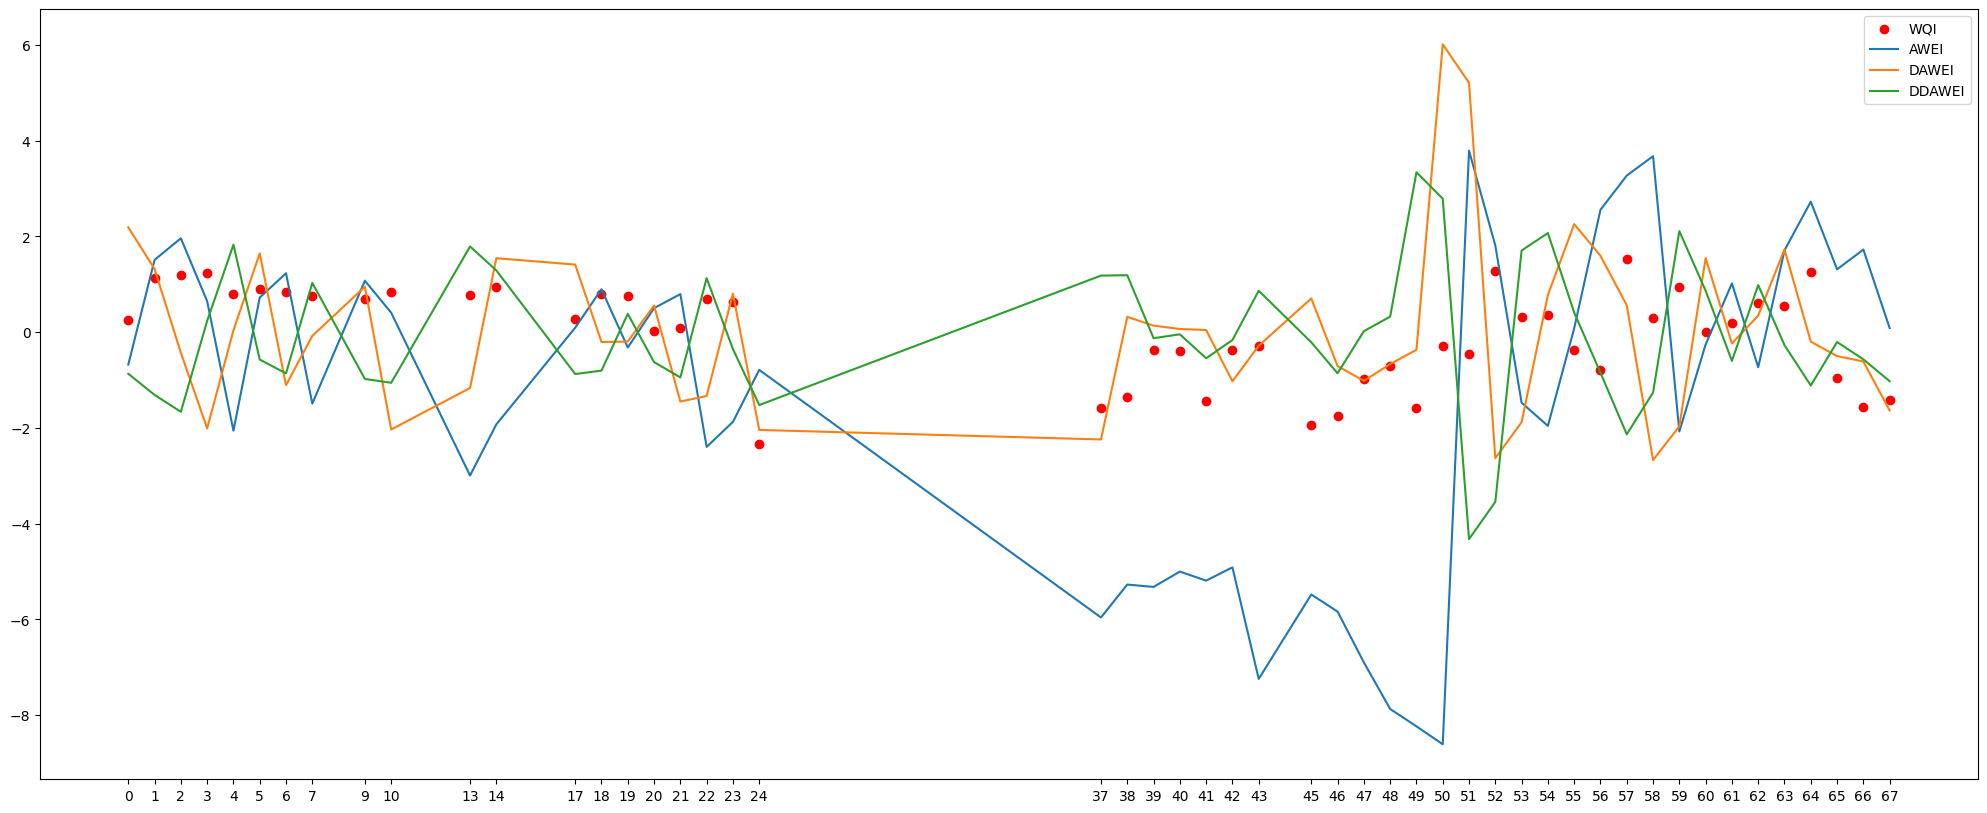

In [ ]:
plt.figure(figsize=(25,10))
gy = (dataframe['WQI'])
gy = (gy - gy.mean())/gy.std()
plt.scatter(Totaldf.index, gy, color="red",label='WQI')
for band in ['AWEI']:
  y = Totaldf[band]
  plt.plot(Totaldf.index, y,label = band)
# ndvi = (Totaldf['B8']- Totaldf['B4'])/ (Totaldf['B8']+ Totaldf['B4'])
# plt.plot(Totaldf.index, ndvi,label = 'ndvi')
plt.plot(Totaldf.index, np.gradient(Totaldf['AWEI']),label = 'DAWEI')
plt.plot(Totaldf.index, np.gradient(np.gradient(Totaldf['AWEI'])),label = 'DDAWEI')
plt.xticks(Totaldf.index)
plt.legend()
plt.show()

In [ ]:
Totaldf['dawei'] = np.gradient(Totaldf['AWEI'])
Totaldf['ddawei']  = np.gradient(Totaldf['dawei'])
Totaldf.corrwith(Totaldf['WQI'])

<ipython-input-497-8191ed9cd048>:3: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Totaldf.corrwith(Totaldf['WQI'])


pH             0.940532
Salinity       0.782753
Carbonate      0.844740
BiCarbonate   -0.053254
Alkalinity     0.264639
Hardness       0.019682
Calcium       -0.764542
Magnesium      0.771399
Ammonia       -0.373276
Coincidence         NaN
B1            -0.694319
B10           -0.362388
B11           -0.571523
B12           -0.534438
B2            -0.680460
B3            -0.619603
B4            -0.648548
B5            -0.665346
B6            -0.651146
B7            -0.638402
B8            -0.652520
B8A           -0.618545
B9            -0.478426
WQI            1.000000
NDWI           0.004200
EWI            0.011442
NWI           -0.201082
diff_B1_B2     0.141223
norm_B9_B11    0.062112
diff_B9_B11    0.141223
AWEI           0.499308
dawei          0.019611
ddawei        -0.087030
dtype: float64

MAE 10.35686158072041
MSE 168.1555714948461
RMSE 12.96748130882964
MAPE 0.3086372856953426
R2 Score -0.05296567686612996


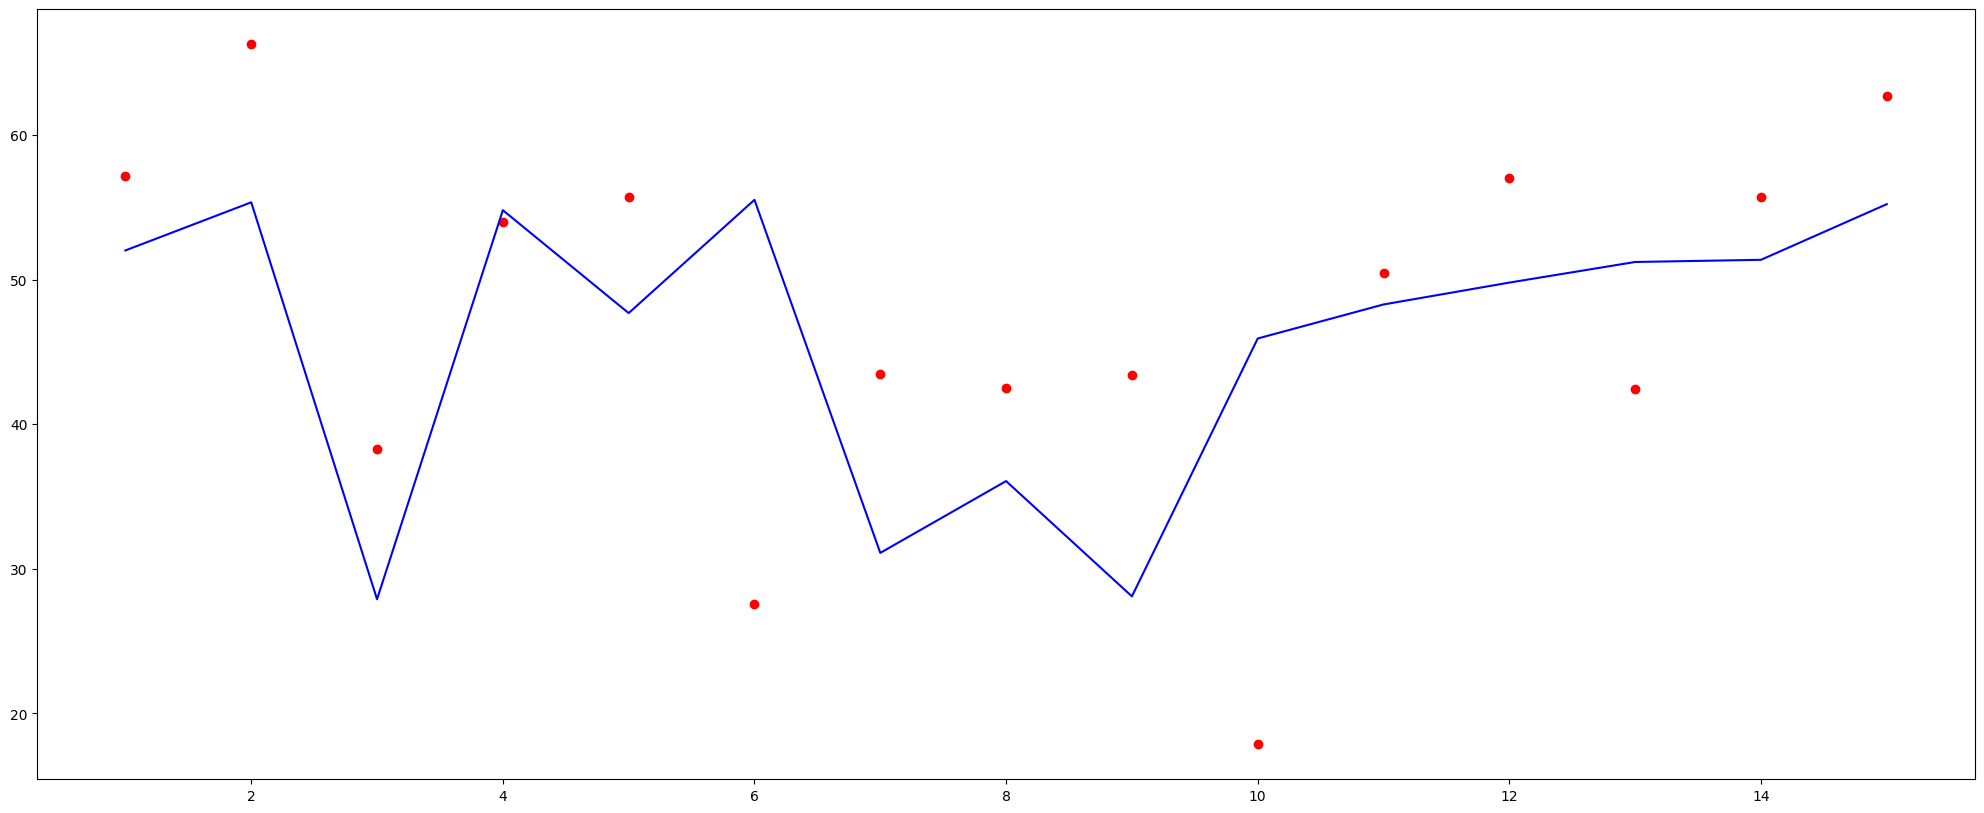

In [ ]:
prediction,gtforRE = predictWQI(Totaldf,'WQI',columns = ['ddawei','dawei','AWEI'])

In [ ]:
estimators = [('Sregr', SVR()),('lrregr', LinearRegression()),('rfregr', RandomForestRegressor()),('nnregre',MLPRegressor()),]

In [ ]:
lpipe = Pipeline(estimators)

In [ ]:
param_grid = dict(Sregr__C=[2 ,3, 4],rfregr__n_estimators=[1, 10, 100],rfregr__max_depth=[2,4,5],nnregre__max_iter = [10000,50000])
grid_search = GridSearchCV(pipe, param_grid=param_grid)

In [ ]:
validationdataframe = dataframe[dataframe["Date of Image"]=="2023-07-09"]
traindataframe = dataframe[dataframe["Date of Image"]!="2023-07-09"]

xTrain = ((traindataframe[bands]))
yTrain = traindataframe[parameters]
xTest = ((validationdataframe[bands]))
yTest = validationdataframe[parameters]

In [ ]:
# grid_search.fit(xTrain,yTrain)